In [1]:
import pandas as pd #For working with data tables and dataframes
import numpy as np #Fro numerical operations
import matplotlib.pyplot as plt #For making plots

The power of the LSTM is in its cell. The cell, in an RNN, is basically the fundamental building block that processes sequential data. It takes in both the current input and the previous cell's output (the hidden state) as input,  and produces a new output and hidden state. 

The gates in an LSTM are what allows it to maintain a long and short term memory. There are 3. 

The Input Gate decides how much new information to keep in the cell state. It uses a sigmoid function tofilter incoming data, determining what weights and biases need to be updated.

The Forget Gate determines how much old information to remove from the cell state. It also uses a sigmoid function to review current inputs and past outputs, and decides wether to retain or discard previous states. The goal is to keep the network free form unnecessary/irrelivant data/

The Output Gate manages what the next hidden layer or the output will receive from the cell state. It uses tanh function on the filtered cell state to scale the values, deciding, based on the sigmoid's state what should be passed onto the output.

This will be shown later

WeightInitializer
- Blueprint for initializing weights for the neural network

In [46]:
class WeightInitializer: 

    #setup function that runs when yyou create a new weight initializer. It remembers the method you want to use for initializing weights, an ddefaults to 'random' if you don't specify one.

    def __init__(self, method='random'): 
        self.method = method

    #This function creates the actual weights. The "shape" tells it how many weights to create and how to arrange them

    def initialize(self, shape):
        if self.method == 'random':
            return np.random.randn(*shape) #Creates random numbers from a bell curve
        elif self.method == 'xavier':
            return np.random.randn(*shape) / np.sqrt(shape[0]) #Divides those random numbers by the square root of the first dimension - this helps prevent numbers from getting too big or small
        elif self.method == 'he':
            return np.random.randn(*shape) * np.sqrt(2. / shape[0]) #Multiplies random numbers by a specific factor
        elif self.method == 'uniform':
            return np.random.uniform(-1, 1, shape) #Creates random numbers evenly spread between -1 and 1
        else:
            raise ValueError("Unknown initialization method: {}".format(self.method))

PlotManager
- Blueprint for plotting loss functions

In [47]:
class PlotManager:

    #This sets up a figure with space for 3 graphs stacked vertically, sized 6 inches wide by 4 inches tall.

    def __init__(self):
        self.fig, self.ax = plt.subplots(3, 1, figsize=(6, 4))

    #This function draws two lines on a graph: One line showing how training loss changed over time. Another line showing validation loss (how well the model performs on data it hasn't seen)

    def plot_losses(self, train_losses, val_losses):
        self.ax.plot(train_losses, label='Training Loss')
        self.ax.plot(val_losses, label='Validation Loss')
        self.ax.set_title('Training and Validation Losses')
        self.ax.set_xlabel('Epoch')
        self.ax.set_ylabel('Loss')
        self.ax.legend()

    #shows the plots

    def show_plots(self):
        plt.tight_layout()

EarlyStopping
- Blueprint for early stopping after a given epoch, in order to prevent overfitting. 
- This class monitors the validation loss and stops training if it does not improve for a specified number of epochs (patience).
- It can also print messages when the loss does not improve, depending on the verbose flag.
Args:
- patience (int): Number of epochs to wait before stopping the training. Default is 7.
- verbose (bool): If True, prints a message for each epoch where the loss does not improve.
- delta (float): Minimum change in the monitored quantity to qualify as an improvement. Default is 0.

In [48]:
class EarlyStopping:

    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience #Number of epochs to wait before stopping
        self.verbose = verbose #If True, prints messages when the loss does not improve
        self.counter = 0 #Counter for how many epochs the loss has not improved
        self.best_score = None #Best score seen so far
        self.early_stop = False #Flag to indicate if training should stop
        self.delta = delta #Minimum change in the monitored quantity to qualify as an improvement

    #This function is called at the end of each epoch to check if the model should stop training based on the validation loss.
    #If the validation loss does not improve for a number of epochs equal to patience, it sets early_stop to True.
    #If verbose is True, it prints a message indicating that the loss did not improve.

    def __call__(self, val_loss):
        #Determines if the model should stop training.

        # Args: val_loss (float): The loss of the model on the validation set.
        
        score = -val_loss #flips the sign of the validation loss to make it a score (lower loss is better)

        if self.best_score is None: 
            self.best_score = score # self.best_score is set to the first score seen

        elif score < self.best_score + self.delta:
            self.counter += 1 # If the score has not improved by at least delta, increment the counter

            if self.counter >= self.patience:
                self.early_stop = True # If the counter exceeds patience, set early_stop to True
        else:
            self.best_score = score
            self.counter = 0 # If the score has improved, reset the counter to 0

Class for LSTM Network

    - input_size: int, dimensionality of input space
    - hidden_size: int, number of LSTM units
    - output_size: int, dimensionality of output space
    - init_method: str, weight initialization method (default: 'xavier')

In [49]:
class LSTM:
    """
    Enhanced Long Short-Term Memory (LSTM) network with better numerical stability.

    Parameters:
    - input_size: int, dimensionality of input space
    - hidden_size: int, number of LSTM units
    - output_size: int, dimensionality of output space
    - init_method: str, weight initialization method (default: 'xavier')
    - dropout_rate: float, dropout rate for regularization (default: 0.0)
    """
    def __init__(self, input_size, hidden_size, output_size, init_method='xavier', dropout_rate=0.0):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_rate = dropout_rate
        self.weight_initializer = WeightInitializer(method=init_method)

        # Initialize weights with proper scaling
        scale_factor = 1.0 / np.sqrt(hidden_size)
        
        # LSTM gate weights
        self.wf = self.weight_initializer.initialize((hidden_size, hidden_size + input_size))
        self.wi = self.weight_initializer.initialize((hidden_size, hidden_size + input_size))
        self.wo = self.weight_initializer.initialize((hidden_size, hidden_size + input_size))
        self.wc = self.weight_initializer.initialize((hidden_size, hidden_size + input_size))

        # Initialize biases - forget gate bias to 1 for better gradient flow
        self.bf = np.ones((hidden_size, 1))  # Start with 1 instead of 0
        self.bi = np.zeros((hidden_size, 1))
        self.bo = np.zeros((hidden_size, 1))
        self.bc = np.zeros((hidden_size, 1))

        # Output layer
        self.why = self.weight_initializer.initialize((output_size, hidden_size)) * scale_factor
        self.by = np.zeros((output_size, 1))

        # For tracking during training
        self.training = True

        self.scale_factor = 1.0 / np.sqrt(hidden_size)  # Scale factor for weight initialization

    def set_training(self, training):
        """Set training mode."""
        self.training = training

    @staticmethod
    def sigmoid(z):
        """Numerically stable sigmoid function."""
        z = np.clip(z, -500, 500)  # Prevent overflow
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def tanh(z):
        """Numerically stable tanh function."""
        z = np.clip(z, -500, 500)  # Prevent overflow
        return np.tanh(z)

    @staticmethod
    def dsigmoid(y):
        """Derivative of sigmoid."""
        return y * (1 - y)

    @staticmethod
    def dtanh(y):
        """Derivative of tanh."""
        return 1 - y * y

    def apply_dropout(self, x, rate):
        """Apply dropout during training."""
        if self.training and rate > 0:
            mask = np.random.binomial(1, 1-rate, x.shape) / (1-rate)
            return x * mask
        return x

    def forward(self, x, return_sequences=False):
        """
        Enhanced forward pass with better numerical stability.
        
        Parameters:
        - x: np.ndarray, input sequences (time_steps, features) or (batch, time_steps, features)
        - return_sequences: bool, whether to return all hidden states or just the last one
        
        Returns:
        - output: np.ndarray, predictions
        - caches: list, cached values for backpropagation
        """
        """
        # Handle both 2D and 3D inputs
        if x.ndim == 3:
            # Batch processing - for now, process first sample
            x = x[0]  # Take first sample in batch
        """
        caches = []
        h_prev = np.zeros((self.hidden_size, 1))
        c_prev = np.zeros((self.hidden_size, 1))
        
        all_outputs = []
        
        for t in range(x.shape[0]):
            x_t = x[t].reshape(-1, 1)
            combined = np.vstack((h_prev, x_t))

            # Gate computations with numerical stability
            f = self.sigmoid(np.dot(self.wf, combined) + self.bf)
            i = self.sigmoid(np.dot(self.wi, combined) + self.bi)
            o = self.sigmoid(np.dot(self.wo, combined) + self.bo)
            c_candidate = self.tanh(np.dot(self.wc, combined) + self.bc)

            # Cell state update
            c = f * c_prev + i * c_candidate
            c = np.clip(c, -10, 10)  # Prevent exploding cell state
            
            # Hidden state
            h = o * self.tanh(c)
            h = self.apply_dropout(h, self.dropout_rate)

            # Cache for backpropagation
            cache = (h_prev, c_prev, f, i, o, c_candidate, x_t, combined, c, h)
            caches.append(cache)

            # Update for next timestep
            h_prev, c_prev = h, c
            
            if return_sequences:
                all_outputs.append(h.copy())

        # Final output
        if return_sequences:
            # Return outputs for all timesteps
            outputs = np.array(all_outputs).squeeze()
            y = np.dot(self.why, outputs[-1].reshape(-1, 1)) + self.by
        else:
            # Return only final output
            y = np.dot(self.why, h) + self.by

        return y, caches

    def backward(self, dy, caches, clip_value=5.0):
        """Enhanced backward pass with gradient clipping."""
        # Initialize gradient accumulators
        dWf = np.zeros_like(self.wf)
        dWi = np.zeros_like(self.wi) 
        dWo = np.zeros_like(self.wo)
        dWc = np.zeros_like(self.wc)
        
        dbf = np.zeros_like(self.bf)
        dbi = np.zeros_like(self.bi)
        dbo = np.zeros_like(self.bo)
        dbc = np.zeros_like(self.bc)
        
        dWhy = np.zeros_like(self.why)
        dby = np.zeros_like(self.by)

        # Ensure proper shape
        dy = dy.reshape(self.output_size, -1)
        dh_next = np.zeros((self.hidden_size, 1))
        dc_next = np.zeros((self.hidden_size, 1))

        # Backward through time
        for idx, cache in enumerate(reversed(caches)):
            h_prev, c_prev, f, i, o, c_candidate, x_t, combined, c, h = cache

            # Output layer gradients (only for last timestep)
            if idx == 0:
                dWhy += np.dot(dy, h.T)
                dby += dy
                dh = np.dot(self.why.T, dy) + dh_next
            else:
                dh = dh_next

            # Cell state gradient
            dc = dc_next + (dh * o * self.dtanh(self.tanh(c)))

            # Gate gradients
            df = dc * c_prev * self.dsigmoid(f)
            di = dc * c_candidate * self.dsigmoid(i)
            do = dh * self.tanh(c) * self.dsigmoid(o)
            dc_candidate = dc * i * self.dtanh(c_candidate)

            # Weight gradients
            dWf += np.dot(df, combined.T)
            dWi += np.dot(di, combined.T)
            dWo += np.dot(do, combined.T)
            dWc += np.dot(dc_candidate, combined.T)

            # Bias gradients
            dbf += df
            dbi += di
            dbo += do
            dbc += dc_candidate

            # Gradients for next iteration
            dcombined = (np.dot(self.wf.T, df) + np.dot(self.wi.T, di) + 
                        np.dot(self.wo.T, do) + np.dot(self.wc.T, dc_candidate))
            
            dh_next = dcombined[:self.hidden_size]
            dc_next = f * dc

        # Collect gradients
        gradients = (dWf, dWi, dWo, dWc, dbf, dbi, dbo, dbc, dWhy, dby)

        # Apply gradient clipping
        clipped_gradients = []
        for grad in gradients:
            clipped_grad = np.clip(grad, -clip_value, clip_value)
            clipped_gradients.append(clipped_grad)

        return (dWf, dWi, dWo, dWc, dbf, dbi, dbo, dbc, dWhy, dby)

    def update_params(self, grads, learning_rate):
        """Update parameters with gradients."""
        dWf, dWi, dWo, dWc, dbf, dbi, dbo, dbc, dWhy, dby = grads

        # Update weights
        self.wf -= learning_rate * dWf
        self.wi -= learning_rate * dWi
        self.wo -= learning_rate * dWo
        self.wc -= learning_rate * dWc

        # Update biases
        self.bf -= learning_rate * dbf
        self.bi -= learning_rate * dbi
        self.bo -= learning_rate * dbo
        self.bc -= learning_rate * dbc

        # Update output layer
        self.why -= learning_rate * dWhy
        self.by -= learning_rate * dby

In [50]:
class LSTMTrainer:
    """
    Enhanced trainer for LSTM with better monitoring and learning rate scheduling.
    """
    def __init__(self, model, learning_rate=0.001, patience=15, verbose=True, delta=1e-6):
        self.model = model
        self.initial_learning_rate = learning_rate
        self.learning_rate = learning_rate
        self.train_losses = []
        self.val_losses = []
        self.early_stopping = EarlyStopping(patience, verbose, delta)
        self.verbose = verbose
        
        # Learning rate scheduling
        self.lr_scheduler = {
            'factor': 0.5,
            'patience': 5,
            'min_lr': 1e-6,
            'wait': 0,
            'best_loss': np.inf
        }

    def compute_loss(self, y_pred, y_true):
        """Compute mean squared error loss with small epsilon for numerical stability."""
        mse = np.mean((y_pred - y_true) ** 2)
        return mse

    def compute_metrics(self, y_pred, y_true):
        """Compute additional metrics for monitoring."""
        mse = np.mean((y_pred - y_true) ** 2)
        mae = np.mean(np.abs(y_pred - y_true))
        
        # R-squared
        ss_res = np.sum((y_true - y_pred) ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
        r2 = 1 - (ss_res / (ss_tot + 1e-8))
        
        return {'mse': mse, 'mae': mae, 'r2': r2}

    def update_learning_rate(self, val_loss):
        """Update learning rate based on validation loss."""
        if val_loss < self.lr_scheduler['best_loss']:
            self.lr_scheduler['best_loss'] = val_loss
            self.lr_scheduler['wait'] = 0
        else:
            self.lr_scheduler['wait'] += 1
            
        if self.lr_scheduler['wait'] >= self.lr_scheduler['patience']:
            old_lr = self.learning_rate
            self.learning_rate = max(
                self.learning_rate * self.lr_scheduler['factor'],
                self.lr_scheduler['min_lr']
            )
            if self.verbose and old_lr != self.learning_rate:
                print(f"Reducing learning rate from {old_lr:.6f} to {self.learning_rate:.6f}")
            self.lr_scheduler['wait'] = 0

    def train(self, X_train, y_train, X_val=None, y_val=None, epochs=100, 
              batch_size=32, clip_value=5.0, validation_split=0.2):
        """
        Enhanced training with better batch processing and monitoring.
        """
        self.model.set_training(True)
        
        # Create validation split if not provided
        if X_val is None and validation_split > 0:
            split_idx = int(len(X_train) * (1 - validation_split))
            X_val, y_val = X_train[split_idx:], y_train[split_idx:]
            X_train, y_train = X_train[:split_idx], y_train[:split_idx]
            if self.verbose:
                print(f"Created validation split: {len(X_train)} train, {len(X_val)} val samples")

        best_val_loss = np.inf
        
        for epoch in range(epochs):
            # Training phase
            self.model.set_training(True)
            epoch_losses = []
            
            # Shuffle training data
            indices = np.random.permutation(len(X_train))
            X_train_shuffled = X_train[indices]
            y_train_shuffled = y_train[indices]
            
            # Mini-batch training
            for i in range(0, len(X_train), batch_size):
                batch_end = min(i + batch_size, len(X_train))
                batch_X = X_train_shuffled[i:batch_end]
                batch_y = y_train_shuffled[i:batch_end]
                batch_grads = None
                batch_loss = 0
                
                batch_losses = []
                
                for x, y_true in zip(batch_X, batch_y):
                    # Forward pass
                    y_pred, caches = self.model.forward(x)
                    loss = self.compute_loss(y_pred, y_true.reshape(-1, 1))
                    batch_losses.append(loss)
                    
                    # Backward pass
                    dy = y_pred - y_true.reshape(-1, 1)
                    grads = self.model.backward(dy, caches, clip_value=clip_value)
                    self.model.update_params(grads, self.learning_rate)

                    if batch_grads is None:
                        batch_grads = grads
                    else:
                        batch_grads = [g_acc + g for g_acc, g in zip(batch_grads, grads)]
                
                epoch_losses.extend(batch_losses)

                batch_grads = [g / len(batch_X) for g in batch_grads]  # Average gradients
                self.model.update_params(batch_grads, self.learning_rate)

                for i in range(len(batch_grads)):
                    batch_grads[i] = np.clip(batch_grads[i], -clip_value, clip_value)  # Clip gradients
            
            # Record training loss
            avg_train_loss = np.mean(epoch_losses)
            self.train_losses.append(avg_train_loss)
            
            # Validation phase
            if X_val is not None and y_val is not None:
                val_loss, val_metrics = self.validate(X_val, y_val)
                self.val_losses.append(val_loss)
                
                # Update learning rate
                self.update_learning_rate(val_loss)
                
                if self.verbose:
                    print(f'Epoch {epoch + 1:3d}/{epochs} - '
                          f'Train Loss: {avg_train_loss:.6f}, '
                          f'Val Loss: {val_loss:.6f}, '
                          f'Val R²: {val_metrics["r2"]:.4f}, '
                          f'LR: {self.learning_rate:.6f}')
                
                # Early stopping check
                self.early_stopping(val_loss)
                if self.early_stopping.early_stop:
                    if self.verbose:
                        print("Early stopping triggered!")
                    break
                    
                # Save best model weights (simplified)
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    
            else:
                if self.verbose:
                    print(f'Epoch {epoch + 1:3d}/{epochs} - Train Loss: {avg_train_loss:.6f}')

        self.model.set_training(False)
        if self.verbose:
            print(f"Training completed. Best validation loss: {best_val_loss:.6f}")

    def validate(self, X_val, y_val):
        """Enhanced validation with metrics."""
        self.model.set_training(False)
        
        val_losses = []
        predictions = []
        actuals = []
        
        for x, y_true in zip(X_val, y_val):
            y_pred, _ = self.model.forward(x)
            loss = self.compute_loss(y_pred, y_true.reshape(-1, 1))
            val_losses.append(loss)
            
            predictions.append(y_pred.flatten())
            actuals.append(y_true.flatten())
        
        predictions = np.concatenate(predictions)
        actuals = np.concatenate(actuals)
        
        avg_val_loss = np.mean(val_losses)
        metrics = self.compute_metrics(predictions, actuals)
        
        return avg_val_loss, metrics

    def predict(self, X_test):
        """Make predictions on test data."""
        self.model.set_training(False)
        predictions = []
        
        for x in X_test:
            y_pred, _ = self.model.forward(x)
            predictions.append(y_pred.flatten())
            
        return np.array(predictions)

    def plot_training_history(self, figsize=(12, 4)):
        """Plot training and validation loss."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        
        # Loss plot
        epochs = range(1, len(self.train_losses) + 1)
        ax1.plot(epochs, self.train_losses, 'b-', label='Training Loss', alpha=0.7)
        if self.val_losses:
            ax1.plot(epochs, self.val_losses, 'r-', label='Validation Loss', alpha=0.7)
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Learning rate plot
        if hasattr(self, 'lr_history'):
            ax2.plot(epochs, self.lr_history, 'g-', alpha=0.7)
            ax2.set_title('Learning Rate Schedule')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Learning Rate')
            ax2.set_yscale('log')
            ax2.grid(True, alpha=0.3)
        else:
            ax2.text(0.5, 0.5, 'Learning Rate\nHistory Not Available', 
                    ha='center', va='center', transform=ax2.transAxes)
            ax2.set_title('Learning Rate Schedule')
        
        plt.tight_layout()
        plt.show()

Importing Dataset from Azure Environment

In [19]:
from azureml.core import Workspace, Dataset

subscription_id = 'b23ddd02-1d4d-4c80-8ef3-f68a97a0dab6'
resource_group = 'MLDev'
workspace_name = 'project_groundhog'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='Treasury')
dataset = dataset.to_pandas_dataframe()
dataset = dataset.dropna()  # Drop rows with NaN values
dataset = dataset.rename(columns={'observation_date': 'Date', 'DGS10': 'Value'})
df = dataset
df

{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe'}
{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe', 'activityApp': 'TabularDataset'}


,Date,Value
0,1962-01-02,4.06
1,1962-01-03,4.03
2,1962-01-04,3.99
3,1962-01-05,4.02
4,1962-01-08,4.03
...,...,...
16575,2025-07-15,4.50
16576,2025-07-16,4.46
16577,2025-07-17,4.47
16578,2025-07-18,4.44


Configuring Dataset into what we need

In [30]:
class TimeSeriesDataset:
    """
    Dataset class for time series data.
    
    Parameters:
    - dataframe: pd.DataFrame, the pandas DataFrame containing your data
    - start_date: str, start date for data retrieval (format: 'YYYY-MM-DD')
    - end_date: str, end date for data retrieval (format: 'YYYY-MM-DD')
    - look_back: int, number of previous time steps to include in each sample
    - train_size: float, proportion of data to use for training (between 0 and 1)
    - date_column: str, name of the date column (default: 'Date')
    - value_column: str, name of the value column (default: 'Value')
    """
    def __init__(self, dataframe, start_date, end_date, look_back=1, train_size=0.67, 
                 date_column='Date', value_column='Value'):
        self.dataframe = dataframe.copy()  # Make a copy to avoid modifying original
        self.start_date = start_date
        self.end_date = end_date
        self.look_back = look_back
        self.train_size = train_size
        self.date_column = date_column
        self.value_column = value_column
        
        # Validate inputs
        if not 0 < train_size < 1:
            raise ValueError("train_size must be between 0 and 1")
        if look_back < 1:
            raise ValueError("look_back must be at least 1")
            
        # Ensure date column is datetime
        if not pd.api.types.is_datetime64_any_dtype(self.dataframe[date_column]):
            print(f"Converting {date_column} to datetime...")
            self.dataframe[date_column] = pd.to_datetime(self.dataframe[date_column])
    
    def load_data(self):
        """
        Load and preprocess the data.
        
        Returns:
        - np.ndarray, training data
        - np.ndarray, testing data
        """
        # Work with a copy of the dataframe
        df = self.dataframe.copy()
        
        # Filter by date range
        start_date = pd.to_datetime(self.start_date)
        end_date = pd.to_datetime(self.end_date)
        
        df = df[(df[self.date_column] >= start_date) & 
                (df[self.date_column] <= end_date)]
        
        if len(df) == 0:
            raise ValueError(f"No data found between {self.start_date} and {self.end_date}")
        
        # Sort by date to ensure chronological order
        df = df.sort_values(by=self.date_column).reset_index(drop=True)
        
        # Extract the value column and ensure it's numeric
        values = df[self.value_column].astype(float).values.reshape(-1, 1)
        
        # Check for any NaN values
        if np.isnan(values).any():
            print("Warning: Found NaN values in data. Consider handling them.")
            # Option: Remove NaN values
            # values = values[~np.isnan(values).any(axis=1)]
        
        # Scale the data
        scaled_values = self.min_max_scaler(values)
        
        # Split into train and test
        train_size = int(len(scaled_values) * self.train_size)
        train_data = scaled_values[:train_size]
        test_data = scaled_values[train_size:]
        
        print(f"Data loaded: {len(scaled_values)} total samples")
        print(f"Training samples: {len(train_data)}")
        print(f"Testing samples: {len(test_data)}")
        
        return train_data, test_data
    
    def min_max_scaler(self, data):
        """
        Min-max scaling of the data to range [0, 1].
        
        Parameters:
        - data: np.ndarray, input data
        
        Returns:
        - np.ndarray, scaled data
        """
        # Store min and max for potential inverse scaling later
        self.data_min = np.min(data, axis=0)
        self.data_max = np.max(data, axis=0)
        
        numerator = data - self.data_min
        denominator = self.data_max - self.data_min
        
        # Add small epsilon to prevent division by zero
        return numerator / (denominator + 1e-8)
    
    def inverse_scale(self, scaled_data):
        """
        Inverse the min-max scaling to get original scale.
        
        Parameters:
        - scaled_data: np.ndarray, scaled data
        
        Returns:
        - np.ndarray, data in original scale
        """
        scaled_data = scaled_data.reshape(-1, 1)  # Ensure 2D
        return scaled_data * (self.data_max - self.data_min) + self.data_min
    
    def create_dataset(self, data):
        """
        Create sequences for time series prediction.
        
        Parameters:
        - data: np.ndarray, input data
        
        Returns:
        - np.ndarray, input sequences (X)
        - np.ndarray, target values (Y)
        """
        if len(data) <= self.look_back:
            raise ValueError(f"Data length ({len(data)}) must be greater than look_back ({self.look_back})")
        
        X, Y = [], []
        
        for i in range(len(data) - self.look_back):
            # Get sequence of length look_back
            sequence = data[i:(i + self.look_back), 0]  # Take first column
            target = data[i + self.look_back, 0]  # Next value
            
            X.append(sequence)
            Y.append(target)
        
        return np.array(X), np.array(Y)
    
    def get_train_test(self):
        """
        Get the complete training and testing datasets.
        
        Returns:
        - np.ndarray, training input sequences
        - np.ndarray, training targets
        - np.ndarray, testing input sequences  
        - np.ndarray, testing targets
        """
        # Load and split the data
        train_data, test_data = self.load_data()
        
        # Create sequences
        trainX, trainY = self.create_dataset(train_data)
        testX, testY = self.create_dataset(test_data)
        
        print(f"Training sequences: {trainX.shape}")
        print(f"Testing sequences: {testX.shape}")
        
        return trainX, trainY, testX, testY
    
    def get_data_info(self):
        """
        Print information about the dataset.
        """
        print(f"Dataset shape: {self.dataframe.shape}")
        print(f"Date range: {self.dataframe[self.date_column].min()} to {self.dataframe[self.date_column].max()}")
        print(f"Value range: {self.dataframe[self.value_column].min():.4f} to {self.dataframe[self.value_column].max():.4f}")
        print(f"Look back: {self.look_back}")
        print(f"Train size: {self.train_size * 100:.1f}%")

In [ ]:
# Instantiate the dataset
dataset = TimeSeriesDataset( dataframe=df, start_date='1962-01-02', end_date='2025-07-21', look_back=5)

dataset.get_data_info()

trainX, trainY, testX, testY = dataset.get_train_test()

# Reshape for LSTM (samples, time steps, features)
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], 1)
testX = testX.reshape(testX.shape[0], testX.shape[1], 1)

print(f"Final training shape: {trainX.shape}")
print(f"Final testing shape: {testX.shape}")



Dataset shape: (15872, 2)
Date range: 1962-01-02 00:00:00 to 2025-07-21 00:00:00
Value range: 0.5200 to 15.8400
Look back: 5
Train size: 67.0%
Data loaded: 15872 total samples
Training samples: 10634
Testing samples: 5238
Training sequences: (10629, 5)
Testing sequences: (5233, 5)
Final training shape: (10629, 5, 1)
Final testing shape: (5233, 5, 1)


'\nlstm = LSTM(input_size=1, hidden_size=hidden_size, output_size=output_size)\n\ntrainer = LSTMTrainer(lstm, learning_rate=1e-3, patience=50, verbose=True, delta=0.001)\ntrainer.train(trainX, trainY, testX, testY, epochs=1000, batch_size=32)\n\nplot_manager = PlotManager()\n\n# Inside your training loop\nplot_manager.plot_losses(trainer.train_losses, trainer.val_losses)\n\n# After your training loop\nplot_manager.show_plots()\n'

In [44]:
#Initialize the LSTM model with enhanced numerical stability
model = LSTM(
    input_size=1, 
    hidden_size=256, 
    output_size=1,
    init_method='xavier',
    dropout_rate=0.2
)

Epoch   1/100 - Train Loss: 0.019138, Val Loss: 0.026221, Val R²: -3.7716, LR: 0.001000
Epoch   2/100 - Train Loss: 0.005884, Val Loss: 0.009399, Val R²: -0.7104, LR: 0.001000
Epoch   3/100 - Train Loss: 0.002419, Val Loss: 0.002560, Val R²: 0.5341, LR: 0.001000
Epoch   4/100 - Train Loss: 0.001333, Val Loss: 0.000633, Val R²: 0.8849, LR: 0.001000
Epoch   5/100 - Train Loss: 0.001010, Val Loss: 0.000169, Val R²: 0.9693, LR: 0.001000
Epoch   6/100 - Train Loss: 0.000880, Val Loss: 0.000057, Val R²: 0.9897, LR: 0.001000
Epoch   7/100 - Train Loss: 0.000902, Val Loss: 0.000043, Val R²: 0.9923, LR: 0.001000
Epoch   8/100 - Train Loss: 0.000865, Val Loss: 0.000033, Val R²: 0.9941, LR: 0.001000
Epoch   9/100 - Train Loss: 0.000887, Val Loss: 0.000029, Val R²: 0.9947, LR: 0.001000
Epoch  10/100 - Train Loss: 0.000845, Val Loss: 0.000030, Val R²: 0.9945, LR: 0.001000
Epoch  11/100 - Train Loss: 0.000865, Val Loss: 0.000028, Val R²: 0.9949, LR: 0.001000
Epoch  12/100 - Train Loss: 0.000815, Val

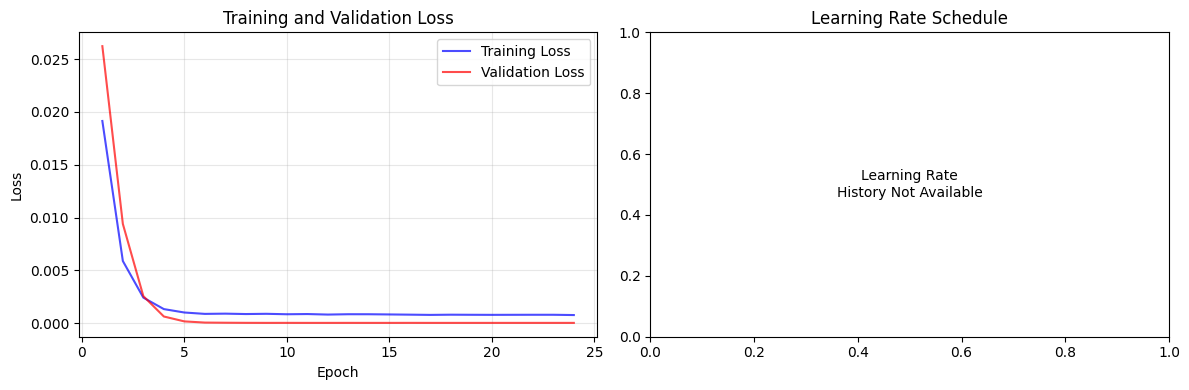

In [45]:
trainer = LSTMTrainer(
    model, 
    learning_rate=0.001, 
    patience=15
)
trainer.train(
    trainX, 
    trainY, 
    X_val=testX, 
    y_val=testY,
    epochs=100,
    batch_size=32
)

trainer.plot_training_history()
predictions = trainer.predict(testX)